## setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('../../..')

In [ ]:
from copulae.input import generate_copula_net_input


from copulae.training.cflax.mlp import MLP
from copulae.training.cflax.mlp import SingleLogitCopula as SLC

from copulae.training.cflax.bilogit import PositiveBiLogitCopula as PBLC
from copulae.training.cflax.bilogit import SiamesePositiveBiLogitCopula as SPBLC

from copulae.training.cflax.binorm import PositiveBiNormalCopula as PBNC
from copulae.training.cflax.binorm import SiamesePositiveBiNormalCopula as SPBNC

from copulae.training.cflax.mono_aux import PositiveLayer
from copulae.training.cflax.mono_aux import (
    EluPOne, Identity, ResELUPlusOne, ResSoftPlus, SoftPlus
)

from copulae.training.loss import sq_error, sq_error_partial, copula_likelihood
from copulae.training.loss import sq_frechet, sq_valid_partial, sq_valid_density
from copulae.training.loss import cross_entropy, cross_entropy_partial

from copulae.training import setup_training

In [ ]:
import jax.numpy as jnp
import jax.scipy.stats as jss
import jax

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import optax

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
def get_model(type, layer_widths):
  # Positive Bi Logit Copula
  if type == 'pblc':
    model = PBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Logit Copula
  elif type == 'spblc':
    model = SPBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Positive Bi Normal Copula
  elif type == 'pbnc':
    model = PBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Normal Copula
  elif type == 'spbnc':
    model = SPBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Single Logit Copula
  elif type == 'slc':
    model = SLC(
        MLP(layer_widths)
    )

  return model

## plot

In [ ]:
# 3.3 polegadas de largura, 1.65 * isso (golden ratio) altura
plt.rcParams['figure.figsize'] = (3.3 * 1.65, 3.3)

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 5

In [ ]:
plt.style.use('tableau-colorblind10') # use um estilo colorblind!
plt.ion()

## data

In [ ]:
import pandas as pd
import scipy
import copy
from scipy import stats

from sklearn.model_selection import train_test_split

In [ ]:
def negative_log_likelihood(Ŷc_batches, I_pdf):
  copula_density = jnp.clip(Ŷc_batches, 1e-6)
  kde_density = jnp.clip(I_pdf, 1e-6)
  return -(jnp.log(copula_density) + jnp.log(kde_density)).mean()

In [ ]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

In [ ]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
np.random.seed(30091985)

In [ ]:
key = jax.random.PRNGKey(30091985)

## imshow

In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
from jax.scipy.stats import gaussian_kde

In [ ]:
def concatenate_cdfs(cdf_x, cdf_y):
  #cumulative_x = np.array(cdf_x)
  #cumulative_y = np.array(cdf_y)

  #cumulative_x = np.expand_dims(cumulative_x, axis=0)
  #cumulative_y = np.expand_dims(cumulative_y, axis=0)

  XY_cumulatives = jnp.concatenate((cdf_x, cdf_y), axis=0)
  #XY_cumulatives = jnp.asarray(XY_cumulatives)
  XY_cumulatives = jnp.expand_dims(XY_cumulatives, axis=0)

  return XY_cumulatives

In [ ]:
def get_density_graph_data2(data_points):
  LOW = 0
  HIGH = 1
  npts = 800

  side = jnp.linspace(LOW, HIGH, npts)
  xx, yy = jnp.meshgrid(side, side)
  points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  densities = kde_x.evaluate(side)
  cumulatives = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in side])

  density_x, _ = jnp.meshgrid(densities, densities)
  density_x = density_x.reshape(-1, 1)
  cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  densities = kde_y.evaluate(side)
  cumulatives = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in side])

  _, density_y = jnp.meshgrid(densities, densities)
  density_y = density_y.reshape(-1, 1)
  _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y
  del _

  return points, I_pdf, cdf_xy

In [ ]:
def make_density_plot(points, joint_density):
  points = points[0]
  heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights=joint_density[0])
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  fig, axes = plt.subplots(1, 1, figsize=(5.5 * 3, 5))
  ax = axes

  ax.invert_yaxis()
  ax.imshow(heatmap.T, origin = 'lower')
  ax.get_xaxis().set_ticks([])
  ax.get_yaxis().set_ticks([])

  plt.show()

## utils

In [ ]:
def L_d(losses, params, state):
  loss = jnp.zeros((1,len(losses)), dtype=jnp.float32)
  for i, (w, loss_func) in enumerate(losses):
    loss = loss.at[0, i].set(loss_func(params, state))
  return loss

In [ ]:
def plot_yyhat(state, TrainingTensors):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].scatter(state.ŶC_batches[0], TrainingTensors[5][0]);
  # axes[0].set(xlim = (0, 1), ylim = (0, 1), )
  axes[0].set(xlim = (min(0, np.min(state.ŶC_batches[0])), max(1, np.max(cop_state.ŶC_batches[0]))), ylim = (0, 1), )
  axes[1].scatter(state.ŶdC_batches[0][0], TrainingTensors[4][0][0]);
  # axes[1].set(xlim = (0, 1), ylim = (0, 1), )
  axes[1].set(xlim = (min(0, np.min(state.ŶdC_batches[0][0])), max(1, np.max(cop_state.ŶdC_batches[0][0]))), ylim = (0, 1), )
  axes[2].scatter(state.ŶdC_batches[0][1], TrainingTensors[4][0][1]);
  # axes[2].set(xlim = (0, 1), ylim = (0, 1), )
  axes[2].set(xlim = (min(0, np.min(state.ŶdC_batches[0][1])), max(1, np.max(cop_state.ŶdC_batches[0][1]))), ylim = (0, 1), )
  plt.show()

In [ ]:
def test_set(D_val, data_points):
  # LOW = 0
  # HIGH = 1
  # npts = 800

  # side = jnp.linspace(LOW, HIGH, npts)
  # xx, yy = jnp.meshgrid(side, side)
  # points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = D_val
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  density_x = kde_x.evaluate(points[0, 0, :])
  cumulative_x = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in points[0, 0, :]])

  # density_x, _ = jnp.meshgrid(densities, densities)
  # density_x = density_x.reshape(-1, 1)
  # cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  density_y = kde_y.evaluate(points[0, 1, :])
  cumulative_y = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in points[0, 1, :]])

  # _, density_y = jnp.meshgrid(densities, densities)
  # density_y = density_y.reshape(-1, 1)
  # _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  I_pdf = jnp.expand_dims(I_pdf, axis=0)
  # cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)
  cdf_xy = jnp.array((cumulative_x, cumulative_y))
  cdf_xy = jnp.expand_dims(cdf_xy, axis=0)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y

  return points, I_pdf, cdf_xy

In [ ]:
def plot_log(log, lim = None):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].plot(np.array(log)[:, 0, 0]);
  axes[1].plot(np.array(log)[:, 0, 1]);
  axes[2].plot(np.array(log)[:, 0, 2]);
  axes[2].set(ylim = lim, )
  plt.show()

In [ ]:
def sanity(state, nn_c, params):
  density_graph_points, I_pdf, cdf_xy = get_density_graph_data2(state.X_batches[0])

  copula_density = nn_c(params, cdf_xy)
  points_density = copula_density * I_pdf

  points = density_graph_points[0]
  heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = points_density[0])
  logheatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = np.log(jnp.clip(points_density[0], 1e-6)))
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))

  axes[0].scatter(
      cop_state.X_batches[0][0, :],
      cop_state.X_batches[0][1, :],
      s=80,
      edgecolor='k',
      alpha=0.5
  );

  axes[1].invert_yaxis()
  axes[1].imshow(heatmap.T, origin = 'lower')
  axes[1].get_xaxis().set_ticks([])
  axes[1].get_yaxis().set_ticks([])

  axes[2].invert_yaxis()
  axes[2].imshow(logheatmap.T, origin = 'lower')
  axes[2].get_xaxis().set_ticks([])
  axes[2].get_yaxis().set_ticks([])
  plt.show()

In [ ]:
import flax.linen as nn

from copulae.typing import Sequence
from copulae.typing import Tensor

class LogitPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        e = jnp.exp(-z)
        return e / (1 + e)

class NormalPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        return jss.norm.pdf(z)

In [ ]:
class MixtureLogitPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += LogitPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv


class MixtureNormalPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += NormalPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv

## Work Folder


In [ ]:
save_root = os.path.join(
            'drive', 'MyDrive', 'copulas',
            'dC_estimator')
os.makedirs(save_root, exist_ok=True)

r2_file = os.path.join(save_root, 'dC_r2.txt')

## Graphs

In [ ]:
def visualize_dC_estimator(TrainingTensors, dU_values, dV_values, wf):
  fig, ax = plt.subplots(1, 1, figsize=(3.3 * 1.65, 3.3))

  ax.scatter(TrainingTensors.YdC_batches[:, 0, :].ravel(),
          dV_values,
          edgecolor='k', alpha=0.5
  )
  ax.set(
      xlabel = 'Estimated First Dev',
      ylabel = 'Real First Dev',
      xlim = (0, 1),
      ylim = (0, 1)
  );
  fig.tight_layout(pad=0)
  plt.savefig(os.path.join(save_root, wf+'dCdv'+'.pdf'))


  fig, ax = plt.subplots(1, 1, figsize=(3.3 * 1.65, 3.3))
  ax.scatter(
      TrainingTensors.YdC_batches[:, 1, :].ravel(),
      dU_values,
      edgecolor='k', alpha=0.5
  )
  ax.set(
      xlabel = 'Estimated First Dev',
      ylabel = 'Real First Dev',
      xlim = (0, 1),
      ylim = (0, 1)
  );
  fig.tight_layout(pad=0)
  plt.savefig(os.path.join(save_root, wf+'dCdu'+'.pdf'))

In [ ]:
def save_fig(TrainingTensors, dU_values, dV_values, wf):
  fig, ax = plt.subplots(1, 1, figsize=(3.3 * 1.65, 3.3))

  ax.scatter(TrainingTensors.YdC_batches[:, 0, :].ravel(),
          dV_values,
          edgecolor='k', alpha=0.5
  )
  ax.set(
      xlabel = 'Estimated First Dev',
      ylabel = 'Real First Dev',
      xlim = (0, 1),
      ylim = (0, 1)
  );
  fig.tight_layout(pad=0)
  plt.savefig(wf+'dCdv'+'.pdf')


  fig, ax = plt.subplots(1, 1, figsize=(3.3 * 1.65, 3.3))
  ax.scatter(
      TrainingTensors.YdC_batches[:, 1, :].ravel(),
      dU_values,
      edgecolor='k', alpha=0.5
  )
  ax.set(
      xlabel = 'Estimated First Dev',
      ylabel = 'Real First Dev',
      xlim = (0, 1),
      ylim = (0, 1)
  );
  fig.tight_layout(pad=0)
  plt.savefig(wf+'dCdu'+'.pdf')

## GT Devs

In [ ]:
import sympy as sp
from sklearn.metrics import r2_score
from scipy import stats

In [ ]:
def copula_frank(u, v, theta):
    return -(1 / theta) * sp.log( ( (1 - sp.exp(-theta)) - ( (1 - sp.exp(-theta * u)) * (1 - sp.exp(-theta * v)) ) ) / (1 - sp.exp(-theta)) )

def frank_GTdC(TrainingTensors, THETA):
  # Variáveis simbólicas
  u, v, theta = sp.symbols('u v theta')

  # Definir a função de Cópula de Frank
  copula = copula_frank(u, v, theta)

  # Calcular as derivadas parciais em relação a u e v
  du = sp.diff(copula, u)
  dv = sp.diff(copula, v)

  U_values = TrainingTensors.UV_batches[0][0]
  V_values = TrainingTensors.UV_batches[0][1]
  dU_values = np.array([du.subs([(u, u_val), (v, v_val), (theta, THETA)]) for u_val, v_val in zip(U_values, V_values)])
  dV_values = np.array([dv.subs([(u, u_val), (v, v_val), (theta, THETA)]) for u_val, v_val in zip(U_values, V_values)])

  return dU_values, dV_values

In [ ]:
def copula_clayton(u, v, theta):
    return (u**(-theta) + v**(-theta) - 1)**(-1/theta)

def clayton_GTdC(TrainingTensors, THETA):
  # Variáveis simbólicas
  u, v, theta = sp.symbols('u v theta')

  # Definir a função de Cópula de Clayton
  copula = copula_clayton(u, v, theta)

  # Calcular as derivadas parciais em relação a u e v
  du = sp.diff(copula, u)
  dv = sp.diff(copula, v)

  U_values = TrainingTensors.UV_batches[0][0]
  V_values = TrainingTensors.UV_batches[0][1]
  dU_values = np.array([du.subs([(u, u_val), (v, v_val), (theta, THETA)]) for u_val, v_val in zip(U_values, V_values)])
  dV_values = np.array([dv.subs([(u, u_val), (v, v_val), (theta, THETA)]) for u_val, v_val in zip(U_values, V_values)])

  return dU_values, dV_values

In [ ]:
def gaussian_GTdC(TrainingTensors, RHO):
  U_values = TrainingTensors.UV_batches[0][0]
  V_values = TrainingTensors.UV_batches[0][1]

  dV_aux = (stats.norm.ppf(U_values) - (stats.norm.ppf(V_values) * RHO) ) / np.sqrt(1 - RHO**2)
  dV_values = stats.norm.cdf(dV_aux)

  dU_aux = (-stats.norm.ppf(U_values)*RHO + (stats.norm.ppf(V_values)) ) / np.sqrt(1 - RHO**2)
  dU_values = stats.norm.cdf(dU_aux)

  return dU_values, dV_values

## Gauss $\rho=0.1$

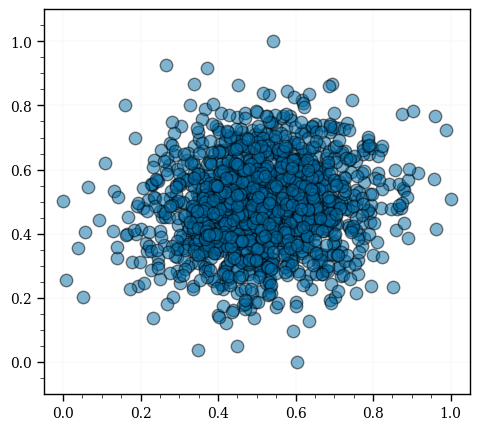

In [ ]:
np.random.seed(30091985)

rho = 0.1
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

visualize_data(train_D)

In [ ]:
dU_values, dV_values = gaussian_GTdC(TrainingTensors, rho)

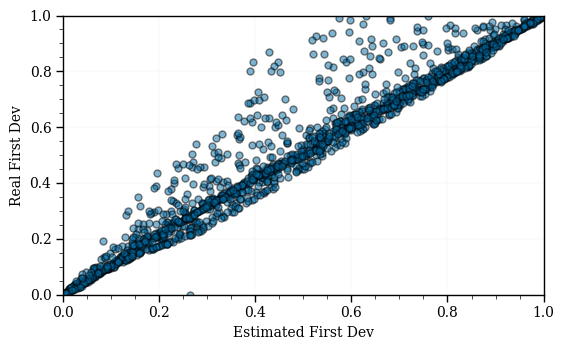

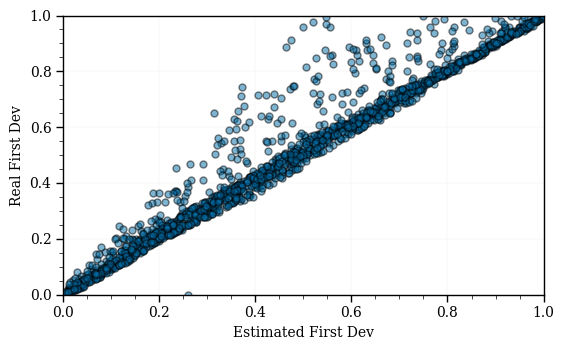

In [ ]:
visualize_dC_estimator(TrainingTensors, dU_values, dV_values, 'gauss01_')

In [ ]:
r2_partial_0 = r2_score(
    TrainingTensors.YdC_batches[:, 0, :].ravel(),
    dV_values
)

r2_partial_1 = r2_score(
    TrainingTensors.YdC_batches[:, 1, :].ravel(),
    dU_values
)

print(f'R2 dCdv: {r2_partial_0}\nR2 dCdu: {r2_partial_1}')

with open(r2_file, 'a') as file:
  file.write(f'{r2_partial_0:.4f}\n{r2_partial_1:.4f}\n')

R2 dCdv: 0.9274833144141581
R2 dCdu: 0.9368267878755127


## Gauss $\rho=0.5$

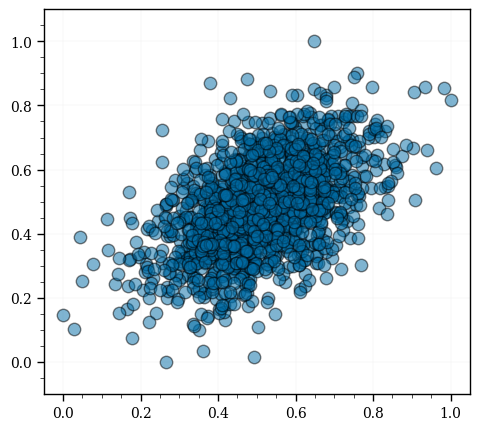

In [ ]:
np.random.seed(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

visualize_data(train_D)

R2 dCdv: 0.9252999195167958
R2 dCdu: 0.9280155677807269


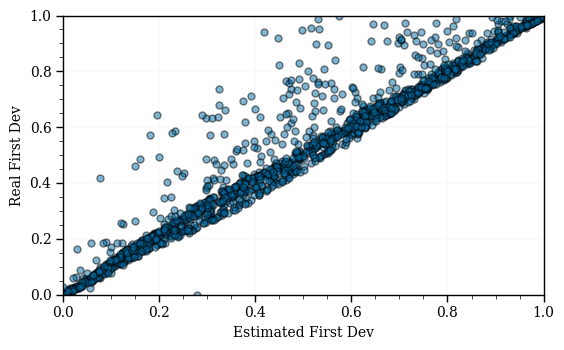

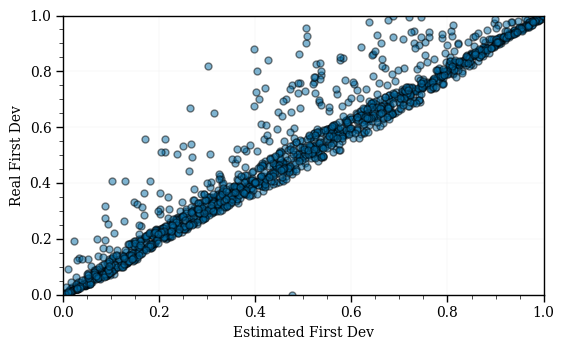

In [ ]:
dU_values, dV_values = gaussian_GTdC(TrainingTensors, rho)
visualize_dC_estimator(TrainingTensors, dU_values, dV_values, 'gauss05_')

r2_partial_0 = r2_score(
    TrainingTensors.YdC_batches[:, 0, :].ravel(),
    dV_values
)

r2_partial_1 = r2_score(
    TrainingTensors.YdC_batches[:, 1, :].ravel(),
    dU_values
)

print(f'R2 dCdv: {r2_partial_0}\nR2 dCdu: {r2_partial_1}')

with open(r2_file, 'a') as file:
  file.write(f'{r2_partial_0:.4f}\n{r2_partial_1:.4f}\n')

## Gauss $\rho=0.9$

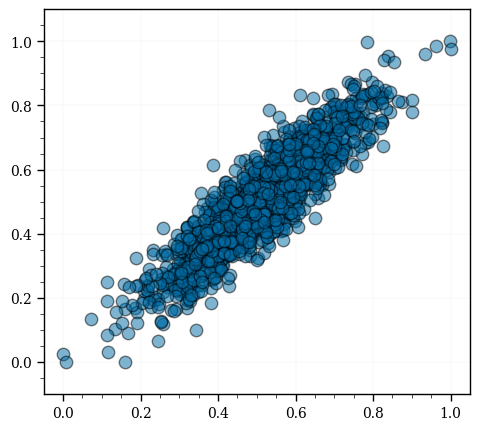

In [ ]:
np.random.seed(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

visualize_data(train_D)

R2 dCdv: 0.937176875374379
R2 dCdu: 0.9341758865890917


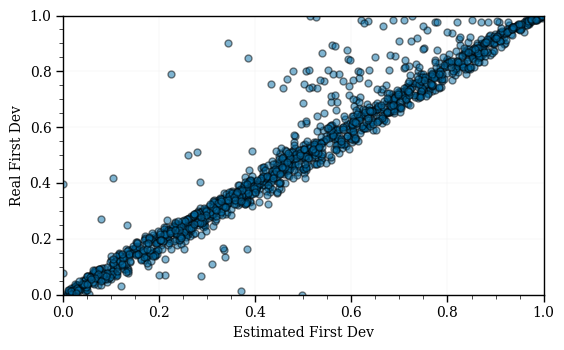

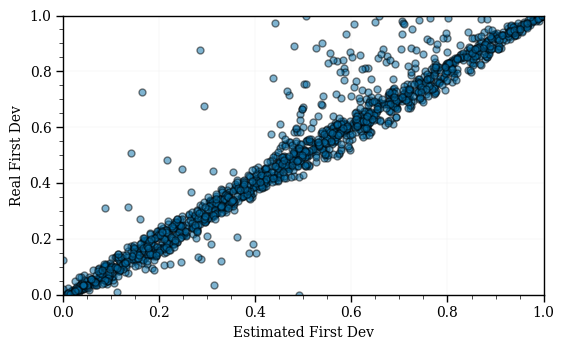

In [ ]:
dU_values, dV_values = gaussian_GTdC(TrainingTensors, rho)
visualize_dC_estimator(TrainingTensors, dU_values, dV_values, 'gauss09_')

r2_partial_0 = r2_score(
    TrainingTensors.YdC_batches[:, 0, :].ravel(),
    dV_values
)

r2_partial_1 = r2_score(
    TrainingTensors.YdC_batches[:, 1, :].ravel(),
    dU_values
)

print(f'R2 dCdv: {r2_partial_0}\nR2 dCdu: {r2_partial_1}')

with open(r2_file, 'a') as file:
  file.write(f'{r2_partial_0:.4f}\n{r2_partial_1:.4f}\n')

## Clayton $\theta = 1$

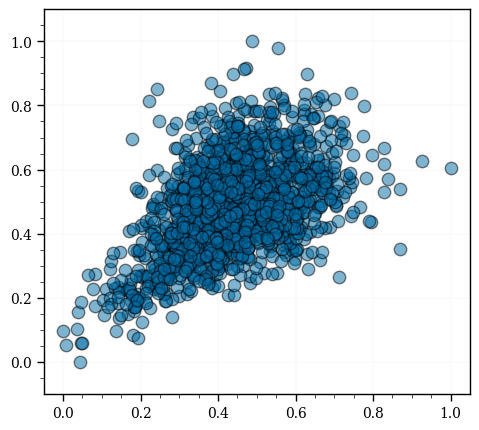

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

visualize_data(train_D)

R2 dCdv: 0.9018469026359872
R2 dCdu: 0.89958172498716


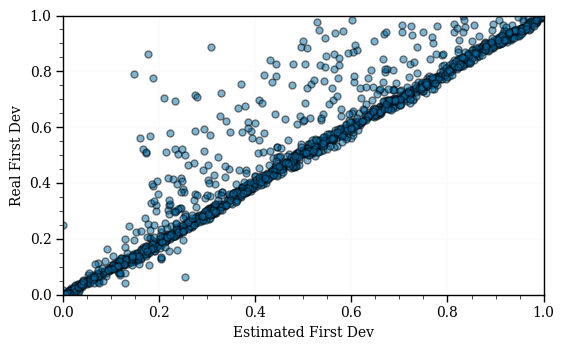

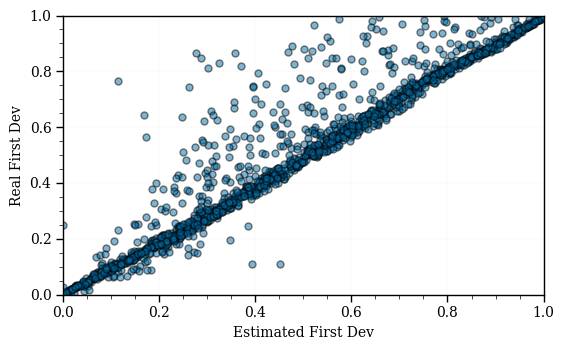

In [ ]:
dU_values, dV_values = clayton_GTdC(TrainingTensors, theta)
visualize_dC_estimator(TrainingTensors, dU_values, dV_values, 'clayton1_')

r2_partial_0 = r2_score(
    TrainingTensors.YdC_batches[:, 0, :].ravel(),
    dV_values
)

r2_partial_1 = r2_score(
    TrainingTensors.YdC_batches[:, 1, :].ravel(),
    dU_values
)

print(f'R2 dCdv: {r2_partial_0}\nR2 dCdu: {r2_partial_1}')

with open(r2_file, 'a') as file:
  file.write(f'{r2_partial_0:.4f}\n{r2_partial_1:.4f}\n')

## Clayton $\theta = 5$

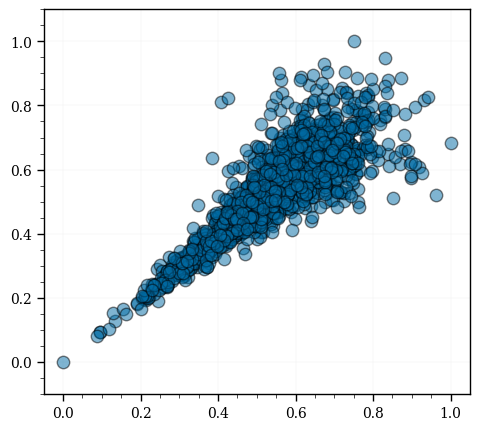

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

visualize_data(train_D)

R2 dCdv: 0.9427342871354581
R2 dCdu: 0.9470291049202072


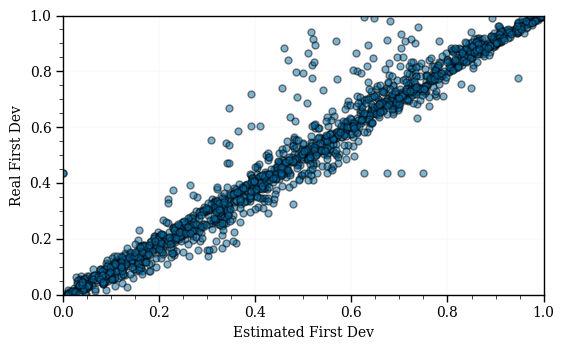

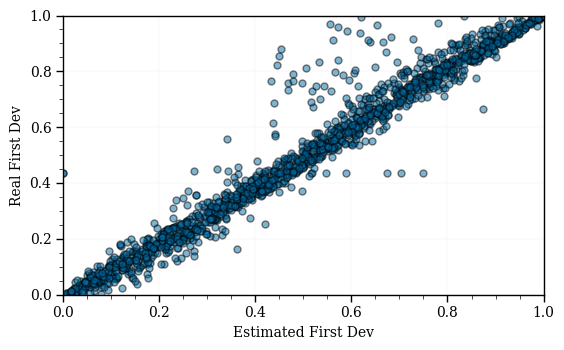

In [ ]:
dU_values, dV_values = clayton_GTdC(TrainingTensors, theta)
visualize_dC_estimator(TrainingTensors, dU_values, dV_values, 'clayton5_')

r2_partial_0 = r2_score(
    TrainingTensors.YdC_batches[:, 0, :].ravel(),
    dV_values
)

r2_partial_1 = r2_score(
    TrainingTensors.YdC_batches[:, 1, :].ravel(),
    dU_values
)

print(f'R2 dCdv: {r2_partial_0}\nR2 dCdu: {r2_partial_1}')

with open(r2_file, 'a') as file:
  file.write(f'{r2_partial_0:.4f}\n{r2_partial_1:.4f}\n')

## Clayton $\theta = 10$

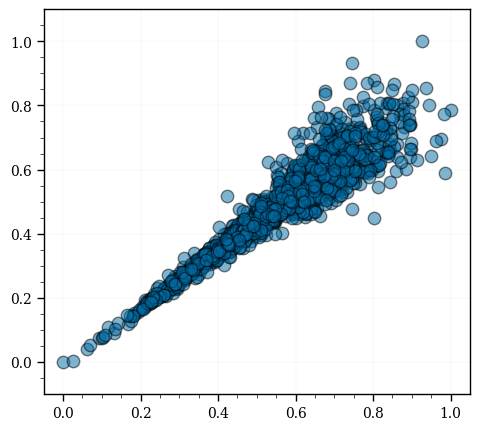

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

visualize_data(train_D)

R2 dCdv: 0.9312328272321578
R2 dCdu: 0.9311990536953431


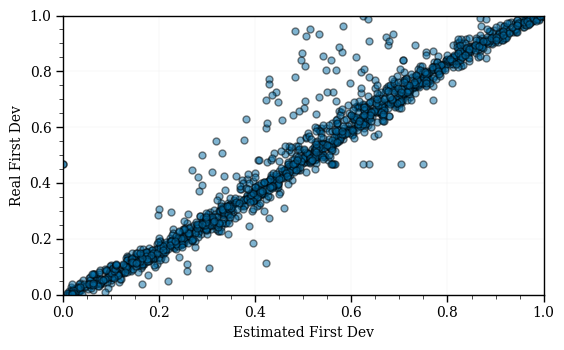

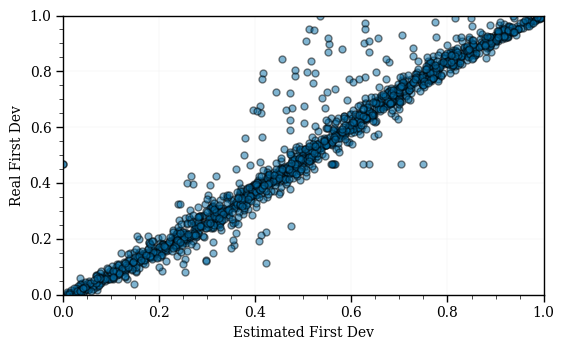

In [ ]:
dU_values, dV_values = clayton_GTdC(TrainingTensors, theta)
visualize_dC_estimator(TrainingTensors, dU_values, dV_values, 'clayton10_')

r2_partial_0 = r2_score(
    TrainingTensors.YdC_batches[:, 0, :].ravel(),
    dV_values
)

r2_partial_1 = r2_score(
    TrainingTensors.YdC_batches[:, 1, :].ravel(),
    dU_values
)

print(f'R2 dCdv: {r2_partial_0}\nR2 dCdu: {r2_partial_1}')

with open(r2_file, 'a') as file:
  file.write(f'{r2_partial_0:.4f}\n{r2_partial_1:.4f}\n')

## Frank $\theta = 1$

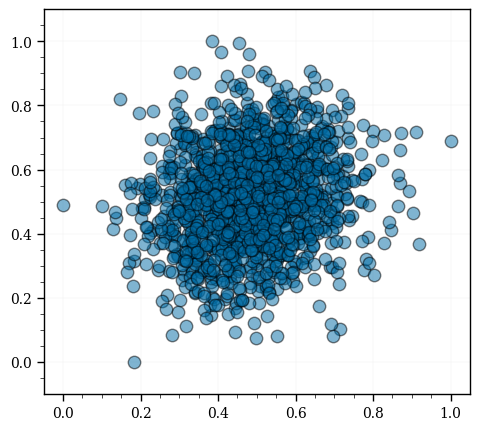

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

visualize_data(train_D)

R2 dCdv: 0.9327707390117531
R2 dCdu: 0.9338273078239482


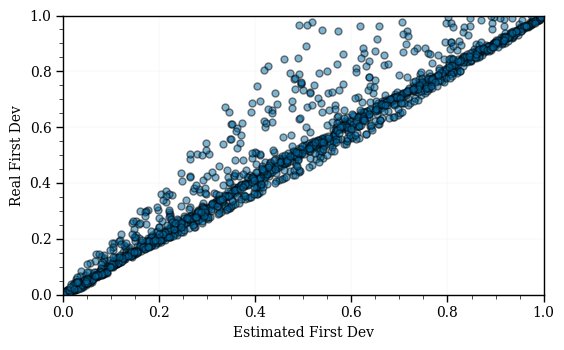

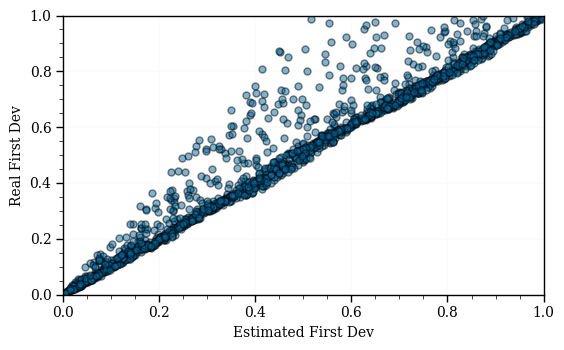

In [ ]:
dU_values, dV_values = frank_GTdC(TrainingTensors, theta)
visualize_dC_estimator(TrainingTensors, dU_values, dV_values, 'frank1_')

r2_partial_0 = r2_score(
    TrainingTensors.YdC_batches[:, 0, :].ravel(),
    dV_values
)

r2_partial_1 = r2_score(
    TrainingTensors.YdC_batches[:, 1, :].ravel(),
    dU_values
)

print(f'R2 dCdv: {r2_partial_0}\nR2 dCdu: {r2_partial_1}')

with open(r2_file, 'a') as file:
  file.write(f'{r2_partial_0:.4f}\n{r2_partial_1:.4f}\n')

## Frank $\theta = 5$

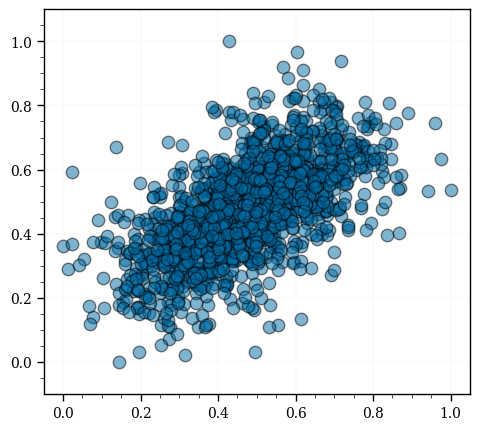

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

visualize_data(train_D)

R2 dCdv: 0.9465788745104767
R2 dCdu: 0.9442981745768942


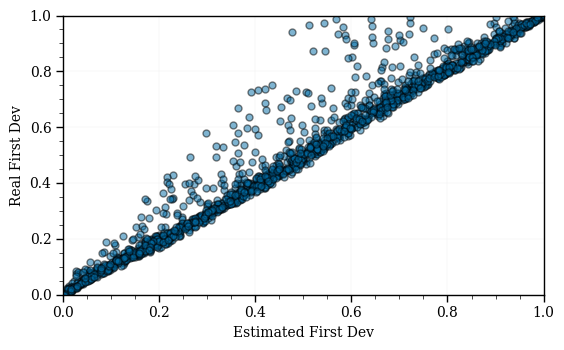

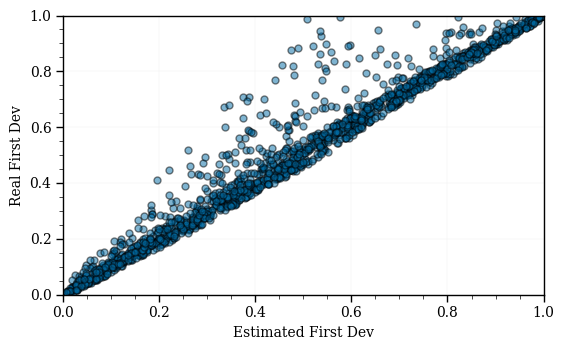

In [ ]:
dU_values, dV_values = frank_GTdC(TrainingTensors, theta)
visualize_dC_estimator(TrainingTensors, dU_values, dV_values, 'frank5_')

r2_partial_0 = r2_score(
    TrainingTensors.YdC_batches[:, 0, :].ravel(),
    dV_values
)

r2_partial_1 = r2_score(
    TrainingTensors.YdC_batches[:, 1, :].ravel(),
    dU_values
)

print(f'R2 dCdv: {r2_partial_0}\nR2 dCdu: {r2_partial_1}')

with open(r2_file, 'a') as file:
  file.write(f'{r2_partial_0:.4f}\n{r2_partial_1:.4f}\n')

## Frank $\theta = 10$

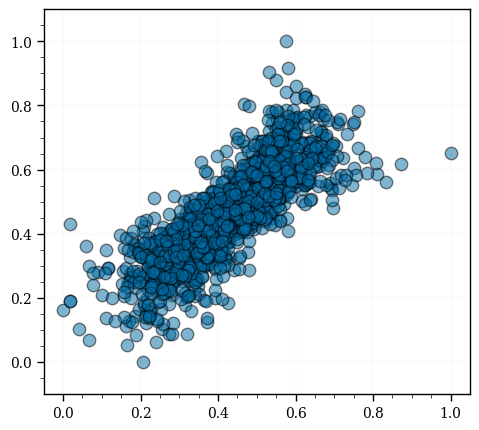

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

visualize_data(train_D)

R2 dCdv: 0.9522410196571189
R2 dCdu: 0.9486713732652503


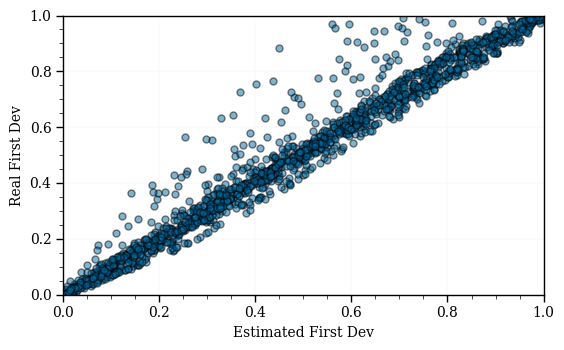

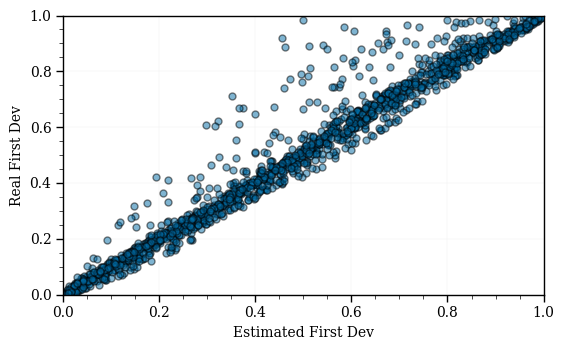

In [ ]:
dU_values, dV_values = frank_GTdC(TrainingTensors, theta)
visualize_dC_estimator(TrainingTensors, dU_values, dV_values, 'frank10_')

r2_partial_0 = r2_score(
    TrainingTensors.YdC_batches[:, 0, :].ravel(),
    dV_values
)

r2_partial_1 = r2_score(
    TrainingTensors.YdC_batches[:, 1, :].ravel(),
    dU_values
)

print(f'R2 dCdv: {r2_partial_0}\nR2 dCdu: {r2_partial_1}')

with open(r2_file, 'a') as file:
  file.write(f'{r2_partial_0:.4f}\n{r2_partial_1:.4f}\n')

Saving image for paper

In [ ]:
dU_values, dV_values = frank_GTdC(TrainingTensors, theta)

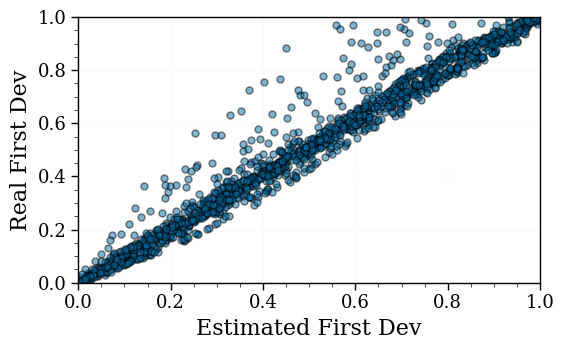

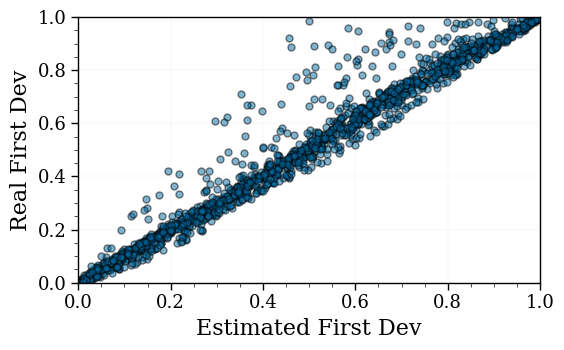

In [ ]:
save_fig(TrainingTensors, dU_values, dV_values, 'frank10_')